In [137]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np

In [138]:
training_data = pd.read_csv("data/training.csv")
training_data.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


In [139]:
id_cols = ['TransactionId', 'SubscriptionId', 'BatchId', 'AccountId','CustomerId','ProductId','ProviderId','ChannelId']
for col in id_cols:
    training_data[col] = training_data[col].apply(lambda x : x.split("_")[-1])

training_data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [140]:
training_data.set_index('TransactionId')
training_data.nunique()
training_data.dtypes

TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object

In [141]:
training_data.drop(['CurrencyCode','CountryCode'],axis = 1, inplace=True)
training_data.set_index('TransactionId')

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,
76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89881,96668,4841,3829,3078,4,6,financial_services,2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
91597,3503,3439,2643,3874,6,10,airtime,3,1000.0,1000,2019-02-13T09:54:25Z,2,0
82501,118602,4841,3829,3874,4,6,financial_services,2,-20.0,20,2019-02-13T09:54:35Z,2,0


## Split Transaction date time

In [142]:
training_data['year'] = pd.to_datetime(training_data['TransactionStartTime']).dt.year
training_data['month'] = pd.to_datetime(training_data['TransactionStartTime']).dt.month
training_data['day'] = pd.to_datetime(training_data['TransactionStartTime']).dt.day
training_data['hour'] = pd.to_datetime(training_data['TransactionStartTime']).dt.hour
training_data['minute'] = pd.to_datetime(training_data['TransactionStartTime']).dt.minute
training_data['second'] = pd.to_datetime(training_data['TransactionStartTime']).dt.second
training_data['day_of_week'] = pd.to_datetime(training_data['TransactionStartTime']).dt.dayofweek


# drop TransactionStartTime
training_data.drop(["TransactionStartTime"] ,axis = 1, inplace=True)
training_data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,year,month,day,hour,minute,second,day_of_week
0,76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2,0,2018,11,15,2,18,49,3
1,73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2,0,2018,11,15,2,19,8,3
2,26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2,0,2018,11,15,2,44,21,3
3,380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2,0,2018,11,15,3,32,55,3
4,28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2,0,2018,11,15,3,34,21,3


In [143]:
training_data.nunique()

TransactionId      95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CustomerId          3742
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
Amount              1676
Value               1517
PricingStrategy        4
FraudResult            2
year                   2
month                  4
day                   31
hour                  24
minute                60
second                60
day_of_week            7
dtype: int64

In [144]:

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(training_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_train.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)
# One-hot encoding removed index; put it back
OH_cols_train.index = training_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_train = training_data.drop("ProductCategory", axis=1)


# Add one-hot encoded columns to numerical features
OH_train = pd.concat([num_train, OH_cols_train], axis=1)

# Ensure all columns have string type
OH_train.columns = OH_train.columns.astype(str)

OH_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,day_of_week,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Mutual Information:

Mutual information measures the relationship between two values, it measures the statistical dependence between two variables, i.e how much knowledge of a variable provides information about the other variable.

In this case we measure the dependence between Fraud result and the other variables. 

In [145]:
OH_train.describe()
OH_train = OH_train.apply(pd.to_numeric,errors = "coerce")
X = OH_train.copy()

y = X.pop('FraudResult')

discrete_features = X.dtypes 
discrete_features

TransactionId          int64
BatchId                int64
AccountId              int64
SubscriptionId         int64
CustomerId             int64
ProviderId             int64
ProductId              int64
ChannelId              int64
Amount               float64
Value                  int64
PricingStrategy        int64
year                   int64
month                  int64
day                    int64
hour                   int64
minute                 int64
second                 int64
day_of_week            int64
ProductCategory_0    float64
ProductCategory_1    float64
ProductCategory_2    float64
ProductCategory_3    float64
ProductCategory_4    float64
ProductCategory_5    float64
ProductCategory_6    float64
ProductCategory_7    float64
ProductCategory_8    float64
dtype: object

In [146]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#mi_scores = make_mi_scores(X, y, discrete_features)
#mi_scores[::3]  

PricingStrategy      0.017041
ChannelId            0.011384
SubscriptionId       0.009336
month                0.006829
ProductCategory_0    0.005685
day                  0.001072
BatchId              0.000333
ProductCategory_1    0.000000
ProductCategory_5    0.000000
Name: MI Scores, dtype: float64

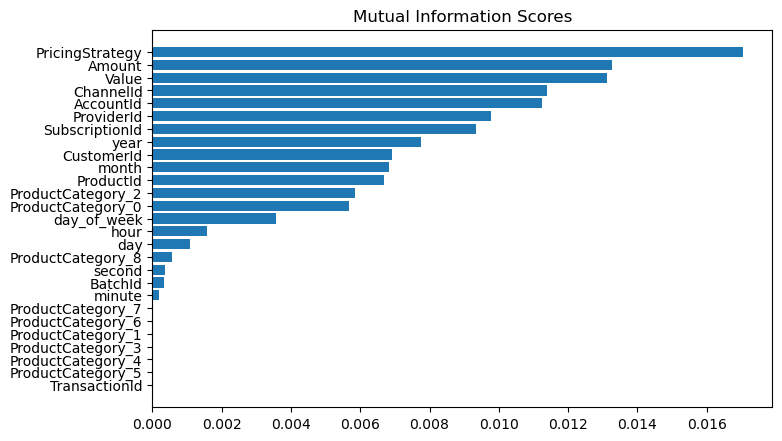

In [147]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


#plt.figure(dpi=100, figsize=(8, 5))
#plot_mi_scores(mi_scores)

## Drop 

In [148]:
OH_train.drop(["minute","second", "year", "month"] ,axis = 1, inplace=True)
OH_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,day_of_week,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
OH_train['morning'] = np.where((OH_train['hour'] >= 5) & (OH_train['hour'] < 13), 1, 0)
OH_train['night'] = np.where((OH_train['hour'] >= 21) | (OH_train['hour'] < 5), 1, 0)
OH_train['afternoon'] = np.where((OH_train['hour'] >= 13) & (OH_train['hour'] < 21), 1, 0)
#OH_train.loc[100:200, ['night','afternoon','morning', 'hour']]
#OH_train.loc[(OH_train.hour >= 23)]
OH_train.drop(["hour"] ,axis = 1, inplace=True)
OH_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8,morning,night,afternoon
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


## Impact of hour (morning, afternoon, night)

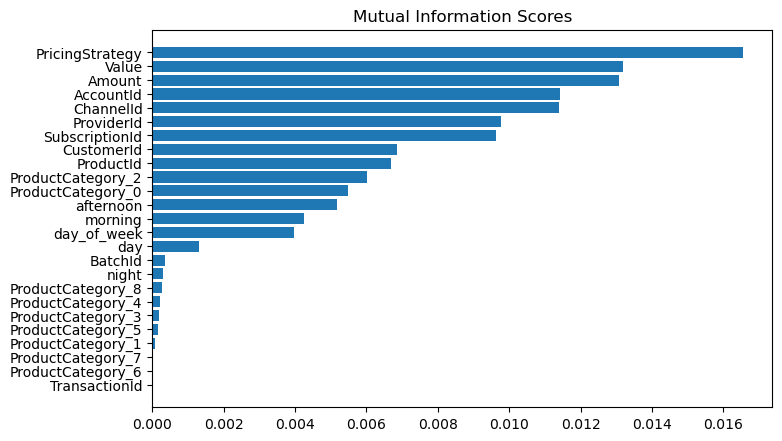

In [150]:
X = OH_train.copy()

y = X.pop('FraudResult')

discrete_features = X.dtypes 

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [154]:
OH_train.to_csv('data/cleaned_data.csv', index=False)

## Model

In [195]:
df = pd.read_csv('data/cleaned_data.csv')
test_data = pd.read_csv('data/test.csv')

test_data.drop(["CurrencyCode", "CountryCode"] ,axis = 1, inplace=True)

# choosing Feautures
training_features = [
    'PricingStrategy', 
    'Value','CustomerId',
    'ProviderId',
    'ProductId',
    'ChannelId',
    'AccountId', 
    'afternoon', 
    'morning', 
    'night', 
    'day_of_week', 
    'ProductCategory_0', 
    'ProductCategory_2']

X = df[training_features]
y = df.FraudResult
X.head()



,PricingStrategy,Value,CustomerId,ProviderId,ProductId,ChannelId,AccountId,afternoon,morning,night,day_of_week,ProductCategory_0,ProductCategory_2
0,2,1000,4406,6,10,3,3957,0,0,1,3,1.0,0.0
1,2,20,4406,4,6,2,4841,0,0,1,3,0.0,1.0
2,2,500,4683,6,1,3,4229,0,0,1,3,1.0,0.0
3,2,21800,988,1,21,3,648,0,0,1,3,0.0,0.0
4,2,644,988,4,6,2,4841,0,0,1,3,0.0,1.0


In [196]:
from imblearn.over_sampling import SMOTE

id_cols = ['TransactionId', 'SubscriptionId', 'BatchId', 'AccountId','CustomerId','ProductId','ProviderId','ChannelId']
for col in id_cols:
    test_data[col] = test_data[col].apply(lambda x : x.split("_")[-1])
    

test_data['day'] = pd.to_datetime(test_data['TransactionStartTime']).dt.day
test_data['hour'] = pd.to_datetime(test_data['TransactionStartTime']).dt.hour
test_data['day_of_week'] = pd.to_datetime(test_data['TransactionStartTime']).dt.dayofweek


# drop TransactionStartTime
test_data.drop(["TransactionStartTime"] ,axis = 1, inplace=True)


OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(test_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_test.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)
# One-hot encoding removed index; put it back
OH_cols_test.index = test_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_test = test_data.drop("ProductCategory", axis=1)


# Add one-hot encoded columns to numerical features
OH_test = pd.concat([num_test, OH_cols_test], axis=1)

# Ensure all columns have string type
OH_test.columns = OH_test.columns.astype(str)


OH_test.dtypes

OH_test['morning'] = np.where((OH_test['hour'] >= 5) & (OH_test['hour'] < 13), 1, 0)
OH_test['night'] = np.where((OH_test['hour'] >= 21) | (OH_test['hour'] < 5), 1, 0)
OH_test['afternoon'] = np.where((OH_test['hour'] >= 13) & (OH_test['hour'] < 21), 1, 0)
#OH_train.loc[100:200, ['night','afternoon','morning', 'hour']]
#OH_train.loc[(OH_train.hour >= 23)]
OH_test.drop(["hour"] ,axis = 1, inplace=True)

#OH_test.head()


In [198]:

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
X_resampled.head()

train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled,random_state = 0)

training_forest_model = RandomForestRegressor(random_state=1)
training_forest_model.fit(train_X, train_y)
train_preds = training_forest_model.predict(OH_test)


ValueError: X has 25 features, but DecisionTreeRegressor is expecting 13 features as input.